## Import libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import pickle as pkl

### Read and preprocess data

In [2]:
# read csv
train = pd.read_csv('data/train_test/train.csv', header = 0)
test = pd.read_csv('data/train_test/test.csv', header = 0)

# split X and y
y_train = train['M']
X_train = train.drop(columns = ['M'])

y_test = test['M']
X_test = test.drop(columns = ['M'])


# data normalization
from sklearn.preprocessing import StandardScaler

# list for cols to scale
cols_to_scale = ['Fe','S1','S2','S3','S4','Ni','Co','Cr','Mn','Se','S','Te']

#create and fit scaler using train data
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

#scale trained data
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])

# scale test data
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# save standard scaler
pkl.dump(scaler, open('models/standard_scaler/scaler.pkl', 'wb'))

In [3]:
# define k-fold object
kfold = KFold(n_splits=10, shuffle=True, random_state=100)

## Stacking 

## Prepare data for stacking

In [5]:
# initialize empty dataframe
results = pd.DataFrame()

#early stopping
es = EarlyStopping(patience=15, monitor='val_loss', mode = 'min')


# initialize 
output_svm = []
output_rf = []
output_ANN = []
output_xgb = []
output_knn = []
output_dt = []
target = []
for train, val in kfold.split(X_train):
        X_train_small, y_train_small = X_train.iloc[train], y_train.iloc[train]
        X_val, y_val = X_train.iloc[val], y_train.iloc[val]

        # model-1
        svr = SVR(C=12)
        svr.fit(X_train_small,y_train_small)
        y_pred_svm = svr.predict(X_val)
        
        # model-2
        rf_reg = RandomForestRegressor(n_estimators=500, min_samples_split = 13)
        rf_reg.fit(X_train_small,y_train_small)
        y_pred_rf = rf_reg.predict(X_val)
        
        # model-3
        knn_reg = KNeighborsRegressor()
        knn_reg.fit(X_train_small,y_train_small)
        y_pred_knn = knn_reg.predict(X_val)
        
        # model-4
        xgb_reg = GradientBoostingRegressor()
        xgb_reg.fit(X_train_small, y_train_small)
        y_pred_xgb = xgb_reg.predict(X_val)
        
        # model-5
        dt_reg = DecisionTreeRegressor()
        dt_reg.fit(X_train_small, y_train_small)
        y_pred_dt = dt_reg.predict(X_val)
        
        # model-6
        # define model
        model = Sequential()
        model.add(Dense(256, activation= 'relu', input_shape = (12,))) #input shape = X_train[0].shape
        model.add(Dense(64, activation= 'relu'))
        model.add(Dense(1))
        model.compile(optimizer= Adam(learning_rate = 0.001), loss='mse')

        # early stopping
        callback = EarlyStopping(patience=7, monitor='val_loss', mode = 'min')
        history = model.fit(X_train_small,y_train_small, epochs = 500,  batch_size=256, verbose=0, validation_data=(X_val, y_val), callbacks = [es])
        y_pred_ann = model.predict(X_val)
        y_pred_ann = y_pred_ann.reshape(y_pred_ann.shape[0],)
        
        #append results
        output_svm.extend(y_pred_svm)
        output_rf.extend(y_pred_rf)
        output_ANN.extend(y_pred_ann)
        output_xgb.extend(y_pred_xgb)
        output_knn.extend(y_pred_knn)
        output_dt.extend(y_pred_dt)
        target.extend(y_val)

In [7]:
# combine predictions
results['svm'] = output_svm
results['rf'] = output_rf
results['ann'] = output_ANN
results['knn'] = output_knn
results['xgb'] = output_xgb
results['dt'] = output_dt
results['target'] = target

In [8]:
X_train_stacking = results[['rf','svm', 'knn', 'ann', 'dt', 'xgb']]
y_train_stacking = results['target']

## Meta Learner CV

In [10]:
# Gradient Boosting

print("XGB")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
reg = GradientBoostingRegressor()

score = cross_val_score(reg, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_squared_error')
print("Scores: ",score,"\n\nNegative Mean Square Error:",score.mean())

print("---------------------")
# R2 Error
score = cross_val_score(reg, X_train_stacking, y_train_stacking, cv= 10)
print("Scores: ",score,"\n\nR2 Mean Score:",score.mean())

# MAE
print("---------------------")
score = cross_val_score(reg, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_absolute_error')
print("Scores: ",score,"\n\nMean Absolute Error:",score.mean())

# SVR
svr = SVR()

print("SVR")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

score = cross_val_score(svr, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_squared_error')
print("Scores: ",score,"\n\nNegative Mean Square Error:",score.mean())
print("---------------------")

# R2 Error
score = cross_val_score(svr, X_train_stacking, y_train_stacking, cv= 10)
print("Scores: ",score,"\n\nR2 Mean Score:",score.mean())

# MAE
print("---------------------")
score = cross_val_score(svr, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_absolute_error')
print("Scores: ",score,"\n\nMean Absolute Error:",score.mean())


# LR
lr = LinearRegression()
print("LR")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

score = cross_val_score(lr, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_squared_error')
print("Scores: ",score,"\n\nNegative Mean Square Error:",score.mean())
print("---------------------")

# R2 Error
score = cross_val_score(lr, X_train_stacking, y_train_stacking, cv= 10)
print("Scores: ",score,"\n\nR2 Mean Score:",score.mean())

# MAE
print("---------------------")
score = cross_val_score(lr, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_absolute_error')
print("Scores: ",score,"\n\nMean Absolute Error:",score.mean())


# rf
rf = RandomForestRegressor()
print("RF")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

score = cross_val_score(rf, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_squared_error')
print("Scores: ",score,"\n\nNegative Mean Square Error:",score.mean())
print("---------------------")

# R2 Error
score = cross_val_score(rf, X_train_stacking, y_train_stacking, cv= 10)
print("Scores: ",score,"\n\nR2 Mean Score:",score.mean())

# MAE
print("---------------------")
score = cross_val_score(rf, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_absolute_error')
print("Scores: ",score,"\n\nMean Absolute Error:",score.mean())

# dt
dt = DecisionTreeRegressor()
print("DT")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

score = cross_val_score(dt, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_squared_error')
print("Scores: ",score,"\n\nNegative Mean Square Error:",score.mean())
print("---------------------")

# R2 Error
score = cross_val_score(dt, X_train_stacking, y_train_stacking, cv= 10)
print("Scores: ",score,"\n\nR2 Mean Score:",score.mean())

# MAE
print("---------------------")
score = cross_val_score(dt, X_train_stacking, y_train_stacking, cv= 10, scoring='neg_mean_absolute_error')
print("Scores: ",score,"\n\nMean Absolute Error:",score.mean())

XGB
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Scores:  [-1.1359125  -1.4740999  -1.13183395 -1.36071174 -0.96411346 -1.72165875
 -1.13442854 -1.77843018 -1.51824696 -1.42675333] 

Negative Mean Square Error: -1.3646189296867814
---------------------
Scores:  [0.95283715 0.94142704 0.9510651  0.9408436  0.95339655 0.9266766
 0.94241598 0.92793287 0.92977886 0.93631784] 

R2 Mean Score: 0.9402691593092303
---------------------
Scores:  [-0.51207738 -0.56762393 -0.50337995 -0.59182881 -0.47509169 -0.61942878
 -0.51522122 -0.58980287 -0.51741879 -0.5530049 ] 

Mean Absolute Error: -0.5444878332929715
SVR
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Scores:  [-1.29652962 -1.48938432 -1.62756521 -1.50590994 -1.03983778 -1.76768695
 -1.13374717 -1.75652622 -1.62541708 -1.4692407 ] 

Negative Mean Square Error: -1.4711844977988506
---------------------
Scores:  [0.94642416 0.94068468 0.93180199 0.93471748 0.95015305 0.92484378
 0.94267199 0.92826669 0.92515056 0.93548337] 

R2 Mean 

## Stacking models 

In [12]:
# Load and prepare models
ANN_model = load_model("ann.h5")

svr = SVR(C=12)
svr.fit(X_train,y_train)

rf_reg = RandomForestRegressor(n_estimators=500, min_samples_split = 13)
rf_reg.fit(X_train,y_train)

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train,y_train)

xgb_reg = GradientBoostingRegressor()
xgb_reg.fit(X_train, y_train)

dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [28]:
# save trained models using pickle
pkl.dump(svr, open('models/base_models/svr.pkl', 'wb'))
pkl.dump(rf_reg, open('models/base_models/rf_reg.pkl', 'wb'))
pkl.dump(knn_reg, open('models/base_models/knn_reg.pkl', 'wb'))
pkl.dump(xgb_reg, open('models/base_models/xgb_reg.pkl', 'wb'))
pkl.dump(dt_reg, open('models/base_models/dt_reg.pkl', 'wb'))

In [29]:
# load saved models
svr = pkl.load(open('models/base_models/svr.pkl', 'rb'))
rf_reg = pkl.load(open('models/base_models/rf_reg.pkl', 'rb'))
knn_reg = pkl.load(open('models/base_models/knn_reg.pkl', 'rb'))
xgb_reg = pkl.load(open('models/base_models/xgb_reg.pkl', 'rb'))
dt_reg = pkl.load(open('models/base_models/dt_reg.pkl', 'rb'))

In [30]:
# prepare new features based on base classifiers
y_pred_train_ann = ANN_model.predict(X_train)
y_pred_train_ann = y_pred_train_ann.reshape(y_pred_train_ann.shape[0],)
y_pred_train_svm = svr.predict(X_train)
y_pred_train_rf = rf_reg.predict(X_train)
y_pred_train_knn = knn_reg.predict(X_train)
y_pred_train_xgb = xgb_reg.predict(X_train)
y_pred_train_dt = dt_reg.predict(X_train)

In [31]:
features = pd.DataFrame()
features['ann'] = y_pred_train_ann
features['svm'] = y_pred_train_svm
features['rf'] = y_pred_train_rf
features['knn'] = y_pred_train_knn
features['xgb'] = y_pred_train_xgb
features['dt'] = y_pred_train_dt
features['target'] = np.array(y_train)

## Train Meta Regression Model

In [32]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_train_stacking = features.iloc[:,:6]
y_train_stacking = features['target']

In [127]:
type(y_train)

pandas.core.series.Series

In [33]:
# train final meta classifier # RF
rf_meta_final = RandomForestRegressor()
rf_meta_final.fit(X_train_stacking, y_train_stacking)

RandomForestRegressor()

In [34]:
# save final meta model and load
pkl.dump(rf_meta_final, open('models/base_models/rf_meta_final.pkl', 'wb'))
rf_meta_final = pkl.load(open('models/base_models/rf_meta_final.pkl', 'rb'))


## Test on independent dataset

In [133]:
# prepare X-Test
# prepare new features based on base classifiers for test set
y_pred_test_ann = ANN_model.predict(X_test)
y_pred_test_ann = y_pred_test_ann.reshape(y_pred_test_ann.shape[0],)
y_pred_test_svm = svr.predict(X_test)
y_pred_test_rf = rf_reg.predict(X_test)
y_pred_test_knn = knn_reg.predict(X_test)
y_pred_test_xgb = xgb_reg.predict(X_test)
y_pred_test_dt = dt_reg.predict(X_test)

# create test data new features
test_features = pd.DataFrame()
test_features['ann'] = y_pred_test_ann
test_features['svm'] = y_pred_test_svm
test_features['rf'] = y_pred_test_rf
test_features['knn'] = y_pred_test_knn
test_features['xgb'] = y_pred_test_xgb
test_features['dt'] = y_pred_test_dt
test_features['target'] = np.array(y_test)

X_test_stacking = test_features.iloc[:,:6]
y_test_stacking = test_features['target']

21/21 [==============================] - 0s 1ms/step


In [135]:
# evaluate results
final_prediction = rf_meta_final.predict(X_test_stacking)
mse = mean_squared_error(final_prediction, y_test_stacking)
r2 = r2_score(final_prediction, y_test_stacking)
mae = mean_absolute_error(final_prediction, y_test_stacking)
print(mse, mae, r2)

1.6556440291957002 0.5468622196855608 0.9227272179004045


In [136]:
pd.DataFrame(final_prediction).to_csv("test_predictions.csv")

In [137]:
pd.DataFrame(y_test_stacking).to_csv("y_test.csv")

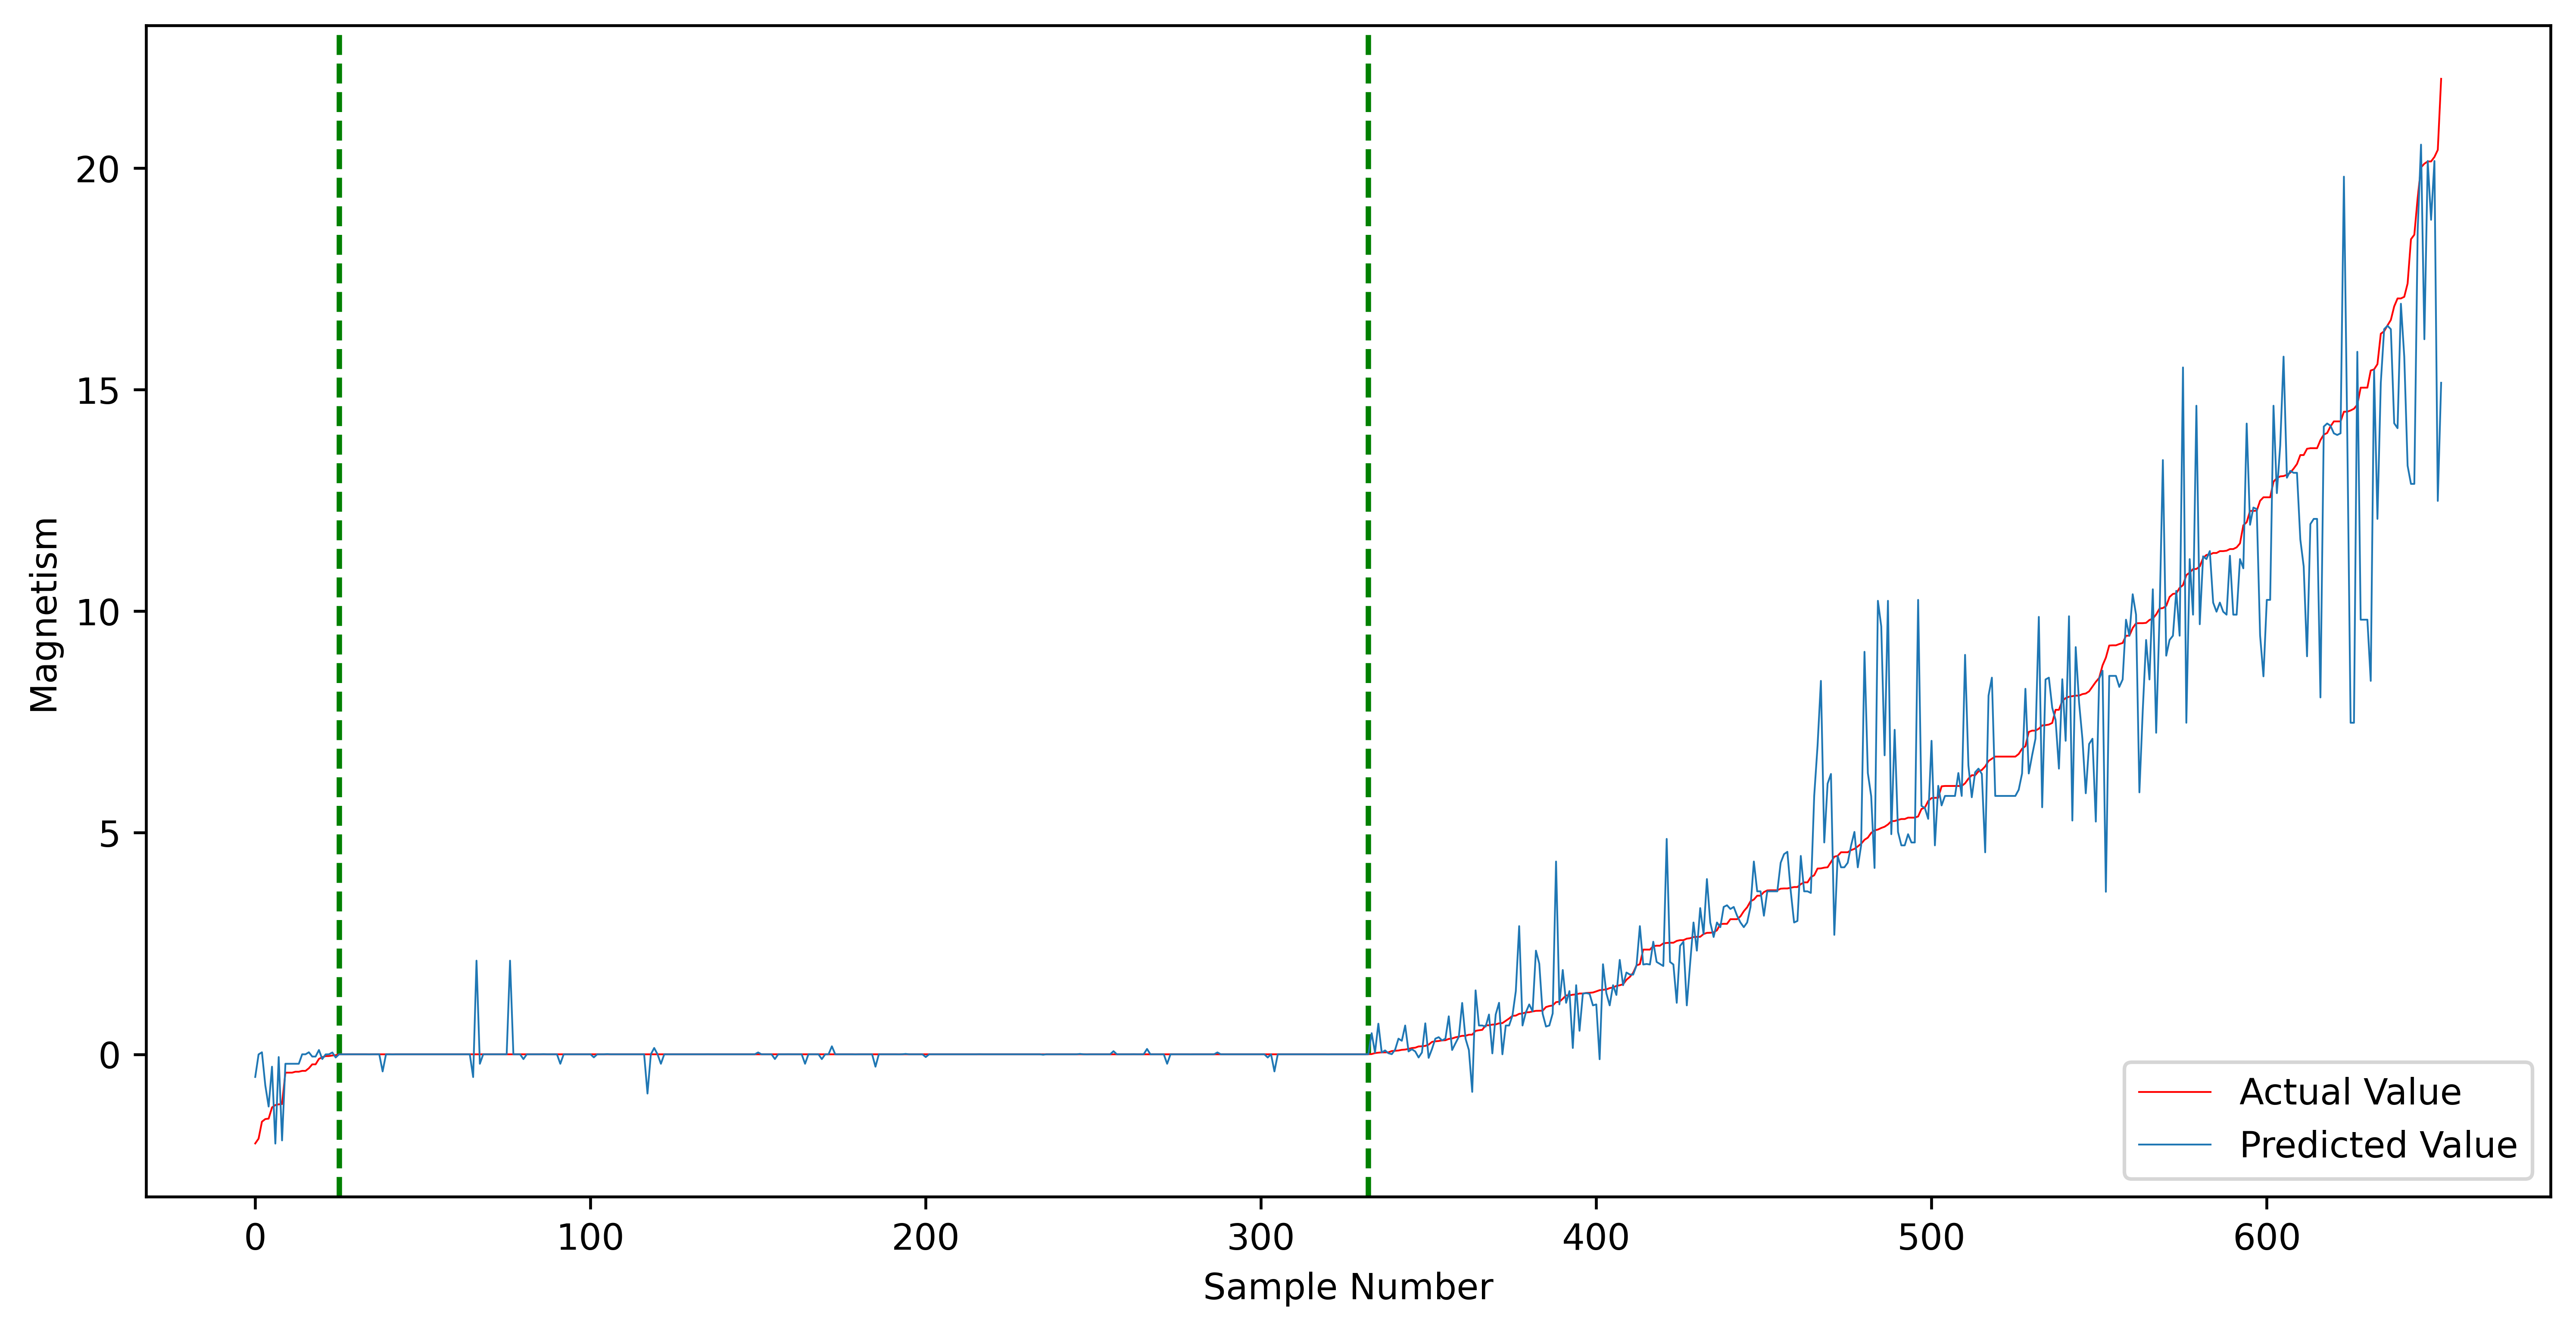

In [1]:
import matplotlib.pyplot as plt

y_test_sorted = [-2.012,-1.903,-1.521,-1.462,-1.452,-1.2,-1.146,-1.129,-1.122,-0.414,-0.414,-0.414,-0.393,-0.393,-0.374,-0.374,-0.315,-0.227,-0.227,-0.104,-0.065,-0.041,-0.039,-0.027,-0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.002,0.005,0.028,0.037,0.043,0.043,0.045,0.073,0.079,0.086,0.101,0.107,0.122,0.141,0.149,0.177,0.181,0.19,0.218,0.28,0.293,0.3,0.314,0.317,0.347,0.357,0.383,0.398,0.417,0.418,0.442,0.444,0.529,0.542,0.553,0.654,0.655,0.67,0.674,0.699,0.704,0.756,0.808,0.868,0.874,0.913,0.922,0.946,0.95,0.967,0.981,0.983,0.984,1.066,1.089,1.102,1.177,1.187,1.253,1.33,1.33,1.345,1.352,1.372,1.372,1.385,1.388,1.395,1.42,1.447,1.456,1.464,1.494,1.508,1.543,1.558,1.581,1.682,1.746,1.839,2.007,2.033,2.363,2.363,2.363,2.441,2.451,2.451,2.504,2.513,2.518,2.518,2.559,2.576,2.576,2.61,2.62,2.646,2.651,2.652,2.714,2.741,2.743,2.752,2.799,2.939,2.945,2.945,3.049,3.049,3.049,3.113,3.229,3.318,3.453,3.493,3.579,3.581,3.661,3.698,3.702,3.702,3.702,3.738,3.743,3.743,3.759,3.775,3.775,3.84,3.88,3.88,3.999,4.041,4.192,4.196,4.212,4.221,4.339,4.46,4.478,4.56,4.56,4.56,4.608,4.636,4.692,4.751,4.841,4.89,4.997,5.053,5.072,5.108,5.136,5.187,5.261,5.265,5.29,5.31,5.31,5.341,5.341,5.341,5.368,5.537,5.566,5.717,5.783,5.788,5.79,6.048,6.056,6.056,6.056,6.056,6.056,6.056,6.116,6.22,6.298,6.298,6.385,6.417,6.496,6.62,6.671,6.719,6.719,6.719,6.719,6.719,6.719,6.719,6.778,6.896,6.954,7.275,7.305,7.305,7.348,7.422,7.429,7.442,7.479,7.775,7.775,7.976,8.039,8.07,8.082,8.095,8.095,8.129,8.143,8.192,8.299,8.405,8.494,8.776,8.953,9.226,9.23,9.23,9.259,9.283,9.447,9.448,9.621,9.727,9.73,9.73,9.737,9.802,9.833,9.927,10.059,10.071,10.121,10.322,10.39,10.402,10.528,10.589,10.815,10.872,10.95,10.954,11.011,11.2,11.27,11.277,11.314,11.314,11.356,11.356,11.366,11.402,11.403,11.441,11.531,11.939,12.008,12.264,12.264,12.269,12.492,12.571,12.571,12.571,12.923,13.004,13.043,13.05,13.079,13.127,13.218,13.322,13.524,13.524,13.666,13.679,13.679,13.679,13.862,13.986,14.022,14.171,14.284,14.284,14.284,14.503,14.503,14.531,14.57,14.662,15.045,15.045,15.046,15.433,15.458,15.576,16.262,16.319,16.45,16.574,16.88,17.059,17.059,17.096,17.397,18.396,18.497,19.33,20.017,20.1,20.151,20.151,20.252,20.412,22.016]
y_pred_sorted_stacking_lr =[-0.51187737,-0.002757206,0.045522793,-0.69974663,-1.179422038,-0.279723636,-2.015323357,-0.061905844,-1.943962762,-0.213653926,-0.213653926,-0.213653926,-0.213653926,-0.213653926,0,0,0.045522793,-0.050710357,-0.050710357,0.096920965,-0.106853153,-0.002048444,0.000499533,0.040870226,-0.072156404,0,0,0,0,0,0,0,0,0,-0.00169,0,0,0,-0.386539673,0,0,-0.002153846,0,0,0,0,0,0,0,2.89E-05,0,0,0,0,0,0,0,0,0,0,0,0,2.89E-05,2.89E-05,0,-0.513697394,2.113393178,-0.213653926,0,0,0,0,0,0,0,0,2.113393178,2.89E-05,0,0,-0.108461008,0,0,0,0,0,0.003096667,0,0,0,0,-0.213653926,0,0,0,0,0,0,0,0,0,-0.068959431,0,0,0,0.004666444,0,0,0,0,0,0,0,0,0,0,0,-0.885813118,0,0.142571559,0,-0.213653926,0,0,0,0,0,0,2.89E-05,0,0,0,0,0,0,0.001094964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.041784379,0,0,0,0,-0.106853153,0,2.89E-05,0,0.001172,0,0,0,0,-0.213653926,0,0,0,0,-0.108461008,0,0,0.180529402,0,2.89E-05,0,0,0,0,-0.002218159,0,0,0,0,0,-0.279723636,0,0,2.89E-05,2.89E-05,0,0,-0.00169,0.001094964,0.008689644,0,0,0,0,0,-0.062008677,0,0,0,0,0,0,0,0,2.89E-05,0,0,0,0,0,0,0.001842,2.89E-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.009110637,0,0,0,0,0,0,0,0,0,0,0.00853,0,-0.002153846,0,0,0,0,0,0,0,0.070411733,0,0,0,0,0,0.001392,0,0,0,0.12118755,0,0,0,0,0,-0.213653926,0,0,0,0,0,0,-0.001235,0,0,0,0,0,0,0,0.041784379,0,0,0,0,0,0,0,0,0,0,2.89E-05,0,0,0,-0.072156404,0,-0.386539673,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.002153846,0,0,2.89E-05,0,2.89E-05,2.89E-05,0,0,0,0,0,0.002309689,0.476042271,0.040870226,0.691057313,0.040870226,0.087786242,0.02431942,0.002937834,0.104350213,0.353309026,0.30536108,0.649927708,0.064128098,0.114409292,0.064128098,-0.072156404,0.040870226,0.698875057,-0.080557157,0.120204214,0.353309026,0.38645948,0.313293133,0.353309026,0.857276044,0.096920965,0.247994722,0.394924167,1.158692763,0.353309026,0.096986048,-0.84807794,1.442872786,0.649927708,0.649927708,0.623661816,0.897520688,0.020459292,0.897520688,1.162000459,0,0.649927708,0.649927708,0.875575825,1.4263,2.892660391,0.649927708,0.948173595,1.125914012,0.969034167,2.339397706,2.044174607,0.916168672,0.626535833,0.649927708,0.922915849,4.350686778,1.125972449,1.902812071,1.162000459,1.4263,0.142549167,1.559513188,0.53110231,1.369595619,1.381039875,1.366427378,1.103835705,1.125972449,-0.111756237,2.032484532,1.381039875,1.103835705,1.559513188,1.339689667,2.130369486,1.559513188,1.845947286,1.800747023,1.79813238,2.003412786,2.892660391,2.026423258,2.038358098,2.026423258,2.54072981,2.084320774,2.038358098,1.992641827,4.861195698,2.084320774,2.026423258,1.162000459,2.447684748,2.54072981,1.103835705,2.055962796,2.974916754,2.339397706,3.299972135,2.713207423,3.954707135,2.974916754,2.647460165,2.974916754,2.869488113,3.32620423,3.363390629,3.279792345,3.325535636,3.127638326,2.974916754,2.869488113,2.974916754,3.32620423,4.350686778,3.678121707,3.678121707,3.127638326,3.678121707,3.678121707,3.678121707,3.678121707,4.322929298,4.51637619,4.570269095,3.684222709,2.974916754,3.00983035,4.476805548,3.678121707,3.678121707,3.641904902,5.831138681,6.961983599,8.42752096,4.780494428,6.109507815,6.326746111,2.695652051,4.476805548,4.220426071,4.220426071,4.322929298,4.712820595,5.018854794,4.219558601,4.714792374,9.084277861,6.347794422,5.825132262,4.205215143,10.23502875,9.656889102,6.747541591,10.23502875,4.967526568,7.323609429,5.018854794,4.715149259,4.715149259,4.967526568,4.780494428,4.780494428,10.25581727,5.605542939,5.560425119,5.314336861,7.075406521,4.715149259,6.058563207,5.616438667,5.831138681,5.831138681,5.831138681,5.831138681,6.347794422,5.831138681,9.014914716,6.517403341,5.801300027,6.363624032,6.447443672,6.326746111,4.558400306,8.095160798,8.500597101,5.831138681,5.831138681,5.831138681,5.831138681,5.831138681,5.831138681,5.831138681,5.970689347,6.337529565,8.249236381,6.337529565,6.747541591,7.122280214,9.872316326,5.575196292,8.459342243,8.500597101,7.819920833,7.547073137,6.447443672,8.464824167,7.075406521,9.8865837,5.275266857,9.190068328,7.945692677,7.122280214,5.891080154,7.002943739,7.122280214,5.251966718,8.477235333,8.657780044,3.667965,8.540524079,8.540524079,8.540524079,8.291993425,8.459342243,9.80878519,9.444401783,10.38289948,9.922130189,5.911199636,7.762495133,9.351235918,8.459342243,10.49505483,7.256525583,9.878697491,13.41145831,8.996608266,9.351235918,9.446907743,10.4598161,9.446907743,15.50181645,7.48242,11.17647872,9.922130189,14.63783231,9.705761512,11.23858661,11.17647872,11.35749513,10.19483663,9.988751032,10.19483663,9.988751032,9.922130189,11.25202345,9.922130189,9.922130189,11.17647872,10.96832486,14.23553133,11.95084565,12.34037176,12.30386114,9.455444813,8.529886131,10.25581727,10.25581727,14.63783231,12.66501387,13.74157021,15.74581917,13.01302323,13.16656747,13.1236589,13.1236589,11.61856063,11.01329852,8.982226877,11.96643243,12.0839156,12.0839156,8.053884732,14.1675505,14.23718036,14.186815,14.01510334,13.97782667,14.01510334,19.8077789,14.00292209,7.48242,7.48242,15.85505295,9.80878519,9.80878519,9.80878519,8.42752096,15.44219622,12.0839156,15.15102724,16.364146,16.44304522,16.364146,14.24146117,14.13093167,16.93948,15.74581917,13.28274769,12.87389938,12.87389938,18.59383417,20.53056286,16.13802903,20.16114376,18.834219,20.16114376,12.48912296,15.15583382]

fig = plt.figure(figsize=(12, 6), dpi=600)
ax = fig.add_subplot(111)

ax.axvline(x=25, color = 'green', linestyle = '--')
ax.axvline(x=332, color = 'green', linestyle = '--')

ax.set_xlabel('Sample Number')
ax.set_ylabel('Magnetism')


ax.plot(y_test_sorted,'r', label = "Actual Value",linewidth=0.5)
ax.plot(y_pred_sorted_stacking_lr, label = "Predicted Value", linewidth=0.5)
ax.legend()

fig.savefig("output_comparison.png", dpi = 600)